# Introduction


Our paper is *"Unifying Heterogeneous Electronic Health Records Systems via Text-Based Code Embedding"* by [**Hur et al.** (2022)](#references). All paper references are provided at the bottom of this notebook.

While EHR (Electronic Health Records) provide an attractive data source to do research on exposures
and disease, there are many heterogenous medical code formats used by different healthcare providers.
Thus, clinical studies using EHRs are difficult to scale up due to data incompatibilities. The techni-
cal hurdle is that previous systems learned hidden representations (latent embeddings) for each code
system which projected the same medical concept with different encodings into different, incompatible
semantic spaces. The paper by [Hur et al (2022)](#references)  learns from the unstructured textual descriptions instead of the medcodes. To this end the authors propose a novel method to unify heterogeneous EHR systems via a novel method to learn text embeddings of medical codes from their textual descriptions, which they call description embedding ([DescEmb](#model)). 
themselves, a strategy which the authors termed description embedding (DescEmb). Using DescEmb
the authors were able to pool differently structured EHRs from two [datasets](#data), namely MIMIC-III and eICU, into one larger pooled
dataset and achieved higher accuracy. The authors then tested the performance of the DescEmb on [five tasks](#prediction_tasks): mortality prediction, length of stay prediction, readmission prediction and diagnosis. 
Hur et al. were to our knowledge the first to attempt a unification of different EHR systems via text-based code embeddings. The authors achieved state-of-the-art performance on all five tasks, which is a significant contribution to the field of EHR research.

# Scope of Reproducibility:

We plan to focus on hypotheses 1 - 3 mainly. Hypothesis 4 is addressed by comparing the results of the proposed method with the state-of-the-art methods (see Results section). Hypothesis 5 is our own hypothesis which we will test by using a BERT model pre-trained on a domain-specific dataset. We view this as an extension of the original paper which is optional, thus it will not be included in the draft. 


1.   Hypothesis 1: *DescEmb* outperforms *CodeEmb*
2.   Hypothesis 2: Two EHR datasets with different structure can be used interchangeably with the proposed method.
3.   Hypothesis 3: Differently structured EHR datasets can be pooled together to improve the performance of the model. 
4.   Hypothesis 4: *DescEmb* has a competitive or superior performance compared to the state-of-the-art methods.
5.   Hypothesis 5 (ours): Using a BERT model which was pre-trained in a strictly domain-specific manner can improve the performance of the model further (not shown by the authors). 


# GitHub repository:

If you entered through a PDF, you can find our GitHub repository [here](https://github.com/constantinkappel/dlh_project). 

# Methodology

## Environment Setup

We provide a [script](setup.sh) to create a virtual environment and install necessary packages.

```bash
./setup.sh
```


In [1]:
# Python version
!python --version

Python 3.12.2


## Imports

In [64]:
from pathlib import Path
import numpy as np
import pandas as pd
from project_code.evaluate.logs import plot_metrics, get_best_epoch, get_metric_at_epoch
from tqdm import tqdm




## Prediction tasks studied in the paper <a id="prediction_tasks"></a>
| Task Number | Task identifier | Task Description | Classification type |
|-------------|---------|---------|--------------|
| Task 1 | Dx | Predicting the diagnosis of a patient given the clinical notes. | Multi-label |
| Task 2 | Mort | Predicting the mortality of a patient given the clinical notes and the treatment codes. | Binary |
| Task 3 | LOS>3 | Predicting whether the length of stay of a patient is greater than 3 days given the clinical notes and the treatment codes. | Binary |
| Task 4 | LOS>7 | Predicting whether the length of stay of a patient is greater than 7 days given the clinical notes and the treatment codes. | Binary |
| Task 5 | ReAdm | Predicting whether a patient will be readmitted within 30 days given the clinical notes and the treatment codes. | Binary |

For task 1 the highest level representation of ICD-9-CM is used, in total 18 representations. MIMIC-III already uses ICD-9, while eICU uses ICD-10. The authors map ICD-10 to ICD-9 using the Clinical Classificatons Software (CCS). 

## Abbreviations used in the paper

| Abbreviation | Description |
|--------------|-------------|
| $p^i$ | The $i$-th patient |
| $c_i$ | The $i$-th medical event (e.g. diagnoses, prescriptions) |
| $\mathcal{C}$ | The set of all medical events |
| $t_i$ | The $i$-th time stamp |
| $w_{i,j}$ | The $j$-th word in the $i$-th medical event |
| $\mathcal{W}$ | The set of all words, i.e. vocabulary of description |
| $d^i$ | The $i$-th text description of diagnosis of the $i$-th patient |
| $E_{\Psi}$ | The embedding layer of the medical events used in *CodeEmb*  |
| $\boldsymbol{c}_i$ | Embedded representation of the $i$-th medical event |
| $B_{\Phi}$ | The embedding layer of the text descriptions used in *DescEmb* |
| $\boldsymbol{z}_i$ | Embedded representation of the $i$-th text description |


# Data <a id="data"></a>


We downloaded two datasets, MIMIC-III v1.4 from [PhysioNet](https://physionet.org/content/mimiciii/1.4/) and eICU v2.0 from [MIT Lab](https://eicu-crd.mit.edu/) and downloaded it via [PhysioNet](https://physionet.org/content/eicu-crd/2.0/) using `wget`. The datasets are stored in the following paths in our Google Drive:

In [5]:
storage_dir = Path("/data/DescEmb/output_predict")
mimic_path = storage_dir/"mimic"
eicu_path = storage_dir/"eicu"
pooled_path = storage_dir/"pooled"

## Data description

eICU consists of 200,859 patients, 1,139,695 admissions, and 2,839,547 patient unit stays. It is organized in three levels:

![](assets/eICU_Fig1.png)

A comprehensive description of the dataset can be found in the paper by [Pollard et al](https://www.nature.com/articles/sdata2018178).

MIMIC-III consists of 46,520 patients, 58,976 admissions, and 7,875,529 clinical notes. An overview of the dataset:

![](assets/MIMIC_Fig1.png)

A comprehensive description of the dataset can be found in the paper by [Johnson et al](https://www.nature.com/articles/sdata201635).

## Preprocessing

We preprocessed the data using the code provided by the authors in their [GitHub repository](https://github.com/hoon9405/DescEmb). We ran
```bash
INPUT_PATH=/home/data
OUTPUT_PATH=/home/data/output
DX_PATH=$INPUT_PATH/ccs_multi_dx_tool_2015.csv

python ../preprocess/preprocess_main.py \
    --src_data mimiciii \
    --dataset_path $INPUT_PATH/mimic \
    --ccs_dx_tool_path $DX_PATH \
    --dest_path $OUTPUT_PATH ;
```
In total this was run six times: For three datasets, i.e. `mimiciii`, `eicu` or `pooled` and `$data_type` was either `predict` or `pretrain` - see our modified [`preprocess_run.sh`](project_code/00_preprocess/preprocess_run.sh) for all six runs. This script needs to be run from within the author's DescEmb repository, because of all the dependencies which `main.py` imports. 
Preprocessing was done on a cloud node with 128 GB of RAM, 32 cores, RTX A6000 GPU and 180 GB of storage.

Both, data cleaning and cohort construction are done by running the same script. Below we describe what is happening in those steps. 

The datasets are constructed such that three sources of information are available:
* Laboratory results
* Medication
* Infusion

Each of these sources is available in two different datasets: MIMIC-III and eICU. The authors use the following files from the MIMIC-III and eICU datasets to construct the datasets for the tasks:

| Item | Source | Filnename |
| --- | --- | --- |
| Laboratory results | MIMIC-III | labevents.csv |
| Medication | MIMIC-III | prescriptions.csv |
| Infusion | MIMIC-III | inputevents_cv.csv, inputevents_mv.csv -> Merged together |
| Laboratory results | eICU | lab.csv |
| Medication | eICU | medication.csv |
| Infusion | eICU | infusionDrug.csv |


### Data Cleaning

On merging inputevents_cv.csv and inputevents_mv.csv, the authors found that the two datasets have different structures. They used the following steps to clean the data:
* 41 patients were removed which conflicted regarding code systems.
* For patients with multiple ICU stays, the authors used the first ICU stay for the analysis.
* For patients with multiple ICU stays, those with fewer than 5 observed codes were removed.
* Restrict sample to first 150 codes during first 12 hours of ICU stay.

### Cohort Construction

The authors used the following steps to construct the cohorts:
1. Cohort: MICU patients whose first care unit was also the last care unit and of type ICU. 
2. Cohort: Patients with multiple ICU stays above age 18
3. Cohort: Patients with multiple ICU stays who remained in ICU for > 12 hours





## Datasets and Dataloaders

In the proposal we intended to leverage `pyhealth` to load the data. However, we found that the authors' code for preprocessing may not be compatible with `pyhealth`. We will use the authors' code to load the data. If we find a path forward for replacing the authors' dataloaders with `pyhealth` we will do so.

Four dataset classes available in `datasets/dataset.py`, all of which inherit from `BaseDataset`, which in turn inherits from `torch.utils.data.Dataset`. The four classes are:

The base class `BaseDataset` provides the following functionality:
* Tokenization of the descriptions with `emilyalsentzer/Bio_ClinicalBERT` via huggingface `transformers`
* Splitting in to folds `train`, `valid` and `test` and return their respective indeces
* A method mask_tokens for preparing masked tokens inputs/labels for masked language modeling (MLM). This method samples tokens in each sequence for MLM training with probabilities for masking, replacing with random tokens, or keeping unchanged.

| Class | Description | Trainer class | `embed_model` |
| --- | --- | --- | --- |
| `CodeDataset` | Dataset for the code embeddings | `Trainer` | `codeemb` |
| `TokenizedDataset` | Dataset for the tokenized descriptions | `Trainer` | `descemb` |
| `MLMTokenizedDataset` | Dataset for the masked language model tokenized descriptions | `Trainer` | `mlm` |
| `Word2VecDataset` | Dataset for the word2vec tokenized descriptions | `Word2VecTrainer` | `w2v` |

`CodeDataset` returns stacked tensors comprising input ID's, sequence length, value and label. 

`TokenizedDataset` stacks input IDs, token type IDs, attention masks, sequential lengths, values, and labels into tensors and organizes them into a dictionary, ready for model input.

`MLMTokenizedDataset` returns input IDs, token type IDs, attention masks, MLM labels for masked language model training. 

`Word2VecDataset` returns an index dictionary as well as positive and negative word pairs to train the word2vec model usin a skip-gram approach.

The datasets are utilized depending on which embedding model is being trained. This decision is made by the user as a command-line argument to `main.py`. There are two trainer classes, one for word2vec and one for all other cases. The table above shows which dataset is used for which embedding model.

## Exploratory Data Analysis

1. Load the data
3. Check the head of the data
7. Check the missing values in the data
9. Check the value counts in the data
8. Check the unique values for categorical features in the data
10. Check demographics of the patients
10. Check the correlation between the features
11. Check the distribution of the features
12. Check the outliers in the data


##### Load the data

In [ ]:
mimic_cohort = pd.read_pickle(storage_dir/"mimiciii_cohort.pkl")
eicu_cohort = pd.read_pickle(storage_dir/"eicu_cohort.pkl")


##### Check the head of the data

In [15]:
mimic_cohort.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,...,EXPIRE_FLAG,age,readmission,mortality,los_3day,los_7day,ICD9_CODE,12h_obs,24h_obs,diagnosis
0,58526,100001,275225,metavision,MICU,MICU,52,52,2117-09-11 11:47:35,2117-09-15 17:57:14,...,0,35,0,0,1,0,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",2117-09-11 23:47:35,2117-09-12 11:47:35,"[10, 6, 3, 7, 12, 17, 13, 9]"
1,54610,100003,209281,metavision,MICU,MICU,50,50,2150-04-17 15:35:42,2150-04-19 14:12:52,...,1,59,0,0,0,0,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,...",2150-04-18 03:35:42,2150-04-18 15:35:42,"[18, 7, 9, 1, 4]"
2,9895,100006,291788,carevue,MICU,MICU,15,15,2108-04-06 15:50:15,2108-04-11 15:18:03,...,1,48,0,0,1,0,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V...",2108-04-07 03:50:15,2108-04-07 15:50:15,"[3, 2, 7, 5, 8]"


In [16]:
eicu_cohort.head(3)

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitdischargelocation,unitdischargestatus,uniquepid,readmission,mortality,losday,los_3day,los_7day,diagnosisstring,diagnosis
0,141392,129109,Female,78,Caucasian,73,97,"Sepsis, renal/UTI (including bladder)",160.0,08:32:00,...,Floor,Alive,002-49989,0,0,0.667361,0,0,[endocrine|glucose metabolism|diabetes mellitu...,"[1, 3, 7]"
1,141462,129166,Male,80,Caucasian,73,97,"Sepsis, pulmonary",170.2,05:27:00,...,Floor,Alive,002-24032,0,0,3.609722,1,0,[endocrine|glucose metabolism|diabetes mellitu...,"[1, 3, 8]"
2,141584,129260,Male,63,Caucasian,73,97,Emphysema/bronchitis,185.4,01:10:00,...,Floor,Alive,002-17958,1,0,2.934028,0,0,"[endocrine|thyroid|hypothyroidism, pulmonary|d...","[3, 8, 18]"


##### Check the missing values in the data

In [17]:
# Check the missing values
print(f"MIMIC-III missing values: {mimic_cohort.isnull().sum()})\n")
print(f"eICU missing values: {eicu_cohort.isnull().sum()})\n")


MIMIC-III missing values: SUBJECT_ID            0
HADM_ID               0
ICUSTAY_ID            0
DBSOURCE              0
FIRST_CAREUNIT        0
LAST_CAREUNIT         0
FIRST_WARDID          0
LAST_WARDID           0
INTIME                0
OUTTIME               0
LOS                   0
GENDER                0
DOB                   0
DOD                8778
DOD_HOSP          11884
DOD_SSN           10321
EXPIRE_FLAG           0
age                   0
readmission           0
mortality             0
los_3day              0
los_7day              0
ICD9_CODE             0
12h_obs               0
24h_obs               0
diagnosis             0
dtype: int64)

eICU missing values: patientunitstayid               0
patienthealthsystemstayid       0
gender                          0
age                             0
ethnicity                      24
hospitalid                      0
wardid                          0
apacheadmissiondx               8
admissionheight                97
hospital

##### Check value counts in the data

##### Check demographics of the patients

In [23]:
mimic_cohort.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE', 'FIRST_CAREUNIT',
       'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME',
       'LOS', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG',
       'age', 'readmission', 'mortality', 'los_3day', 'los_7day', 'ICD9_CODE',
       '12h_obs', '24h_obs', 'diagnosis'],
      dtype='object')

<Axes: xlabel='age', ylabel='Count'>

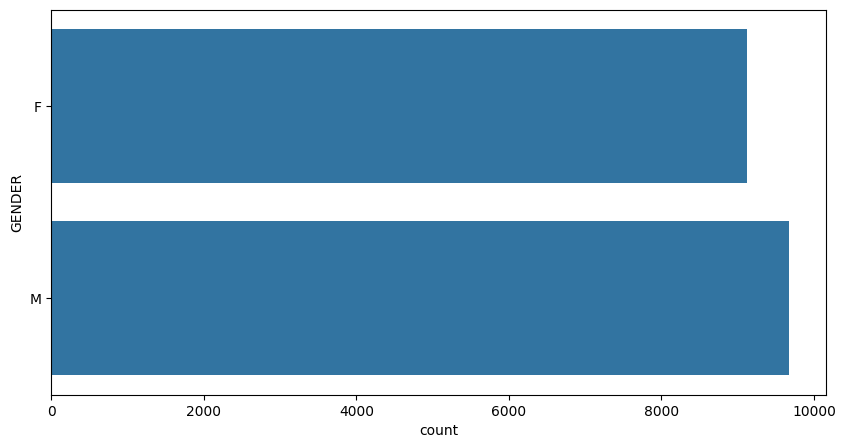

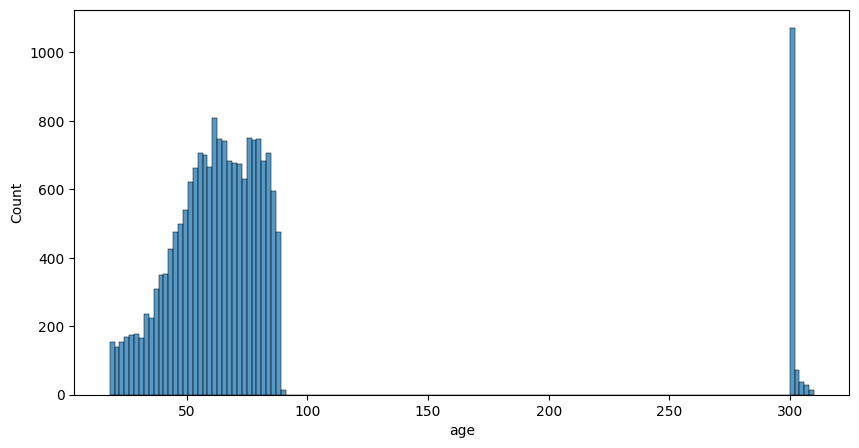

In [26]:
# demographics in MIMIC-III: GENDER, age
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(mimic_cohort['GENDER'])
plt.figure(figsize=(10, 5))
sns.histplot(mimic_cohort['age'])

In [29]:
eicu_cohort.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset',
       'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid', 'readmission', 'mortality', 'losday', 'los_3day',
       'los_7day', 'diagnosisstring', 'diagnosis'],
      dtype='object')

<Axes: xlabel='ethnicity', ylabel='Count'>

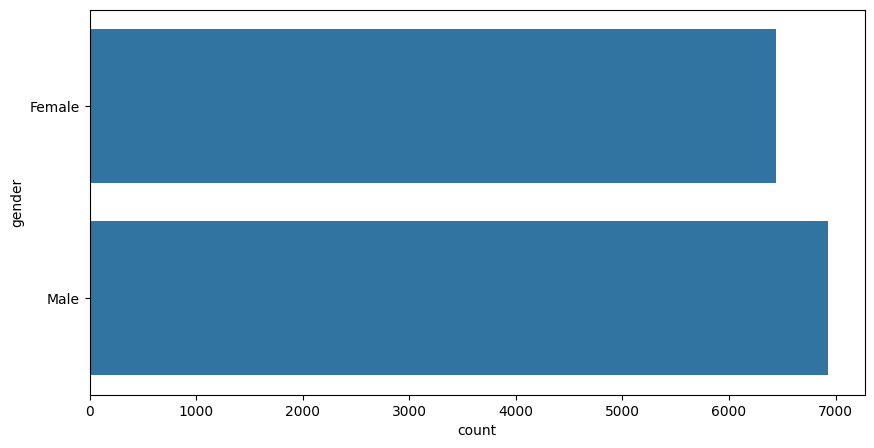

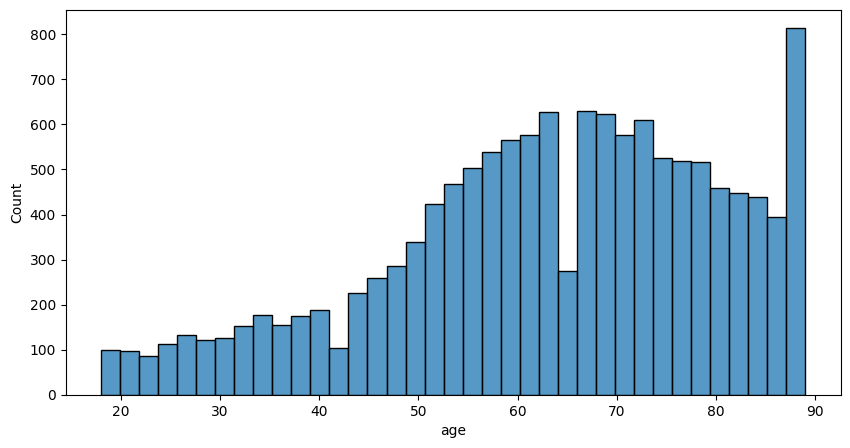

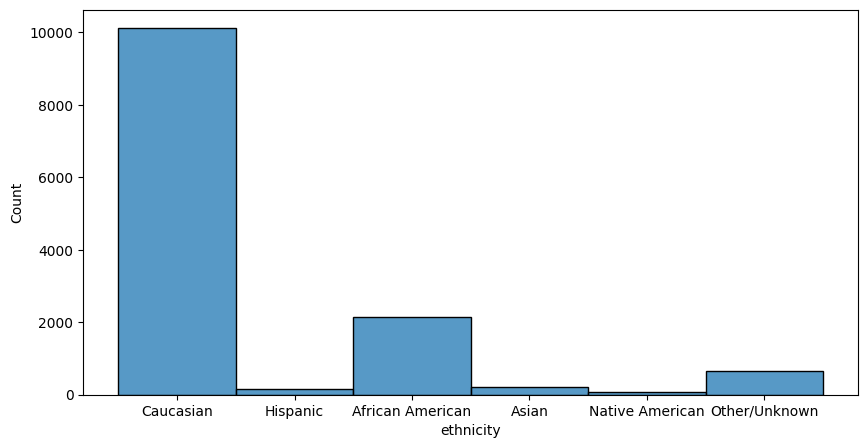

In [32]:
# demographics in eicu: gender, age
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(eicu_cohort['gender'])
plt.figure(figsize=(10, 5))
sns.histplot(eicu_cohort['age'])
plt.figure(figsize=(10, 5))
sns.histplot(eicu_cohort['ethnicity'])

#   Model <a id="model"></a>
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

## *CodeEmb* vs. *DescEmb* strategies

The authors propose two strategies to embed the data: *CodeEmb* and *DescEmb*. The two strategies are described as follows:

$$

\begin{align*}
  \textit{Code-based Embedding:} \\
  &\boldsymbol{c}_i = E_{\Psi}(\boldsymbol{c}_i) \\
  &\hat{y} = P_{\Phi}(\boldsymbol{c}_1, \boldsymbol{c}_2, ..., \boldsymbol{c}_T) \\  
  \textit{Description-based Embedding:} \\
  &d_i = (w_{i,1}, w_{i,2}, ... , w_{i,n}) \\
  &\boldsymbol{z}_i = B_{\Psi}(d_i)  \\
  &\hat{y} = P_{\Phi}(\boldsymbol{z}_1, \boldsymbol{z}_2, ..., \boldsymbol{z}_T )
\end{align*}

$$ 

Effectively, the *CodeEmb* strategy uses the medical events directly, while the *DescEmb* strategy uses the text descriptions of the medical events. The authors use a Bi-LSTM for the embedding layer $E_{\Psi}$ in *CodeEmb*. For  $B_{\Psi}$ they ended up using a BERT (Bi-directional Encoder Representations from Transformers). While the authors tested several model depths, we will only use the smallest 2-MSA-layer model **BERT-tiny**. For the most part $\boldsymbol{z_i}$ corresponds to the BERT output vector for the *[CLS]* token. The prediction layer $P_{\Phi}$ employs an RNN.

## Value Embedding

The descriptions of medical events often contain numbers (values), which are important for the prediction tasks. The authors propose four different methods to embed these values into the model. The methods is described as follows:

* Value Aggregation (VA): All numbers are used as is and embedded into a single vector. This has two disadvanteges
  - Use a lot of rare (in the Zipfian sense) tokens for all the numbers
  - Prone to sub-word tokenization (e.g. `1351` gets split into `13` and `15`) 
* Digit-split value aggregation (DSVA): The numbers are split into digits and embedded separately. This has the advantage of not needing rare tokens, but the disadvantage of not capturing the value as a whole.
* DSVA + Digit Place Embedding (DSVA-DPE): The numbers are split into digits and embedded separately. Additionally, the place of the digit is embedded. This has the advantage of capturing the value as a whole, but the disadvantage of needing more tokens.
* Value Concatenated (VC): Numbers and their corresponding physical units are embedded and then concatenated. This has the advantage of capturing the value as a whole and the physical unit, but the disadvantage of needing more tokens. The value embeddings in this case is done using a single layer feed-forward neural network (MLP or `nn.Linear` in PyTorch).

The following figure summarizes the value embedding techniques. 

![](assets/Fig3.png)

## Model Training

There are three optimization schemes used in the paper:

$$
\begin{align}
  \textit{CodeEmb}: argmin_{\Theta, \Psi} \mathcal{L}(\hat{y}, y) \\
  \textit{DescEmb, all parameters}: argmin_{\Theta, \Phi} \mathcal{L}(\hat{y}, y) \\
  \textit{DescEmb, class fine-tuning}: argmin_{\Psi, \boldsymbol{z}_{CLS}} \mathcal{L}(\hat{y}, y) \\
\end{align}
$$

Eqn. 1 is the optimization scheme for *CodeEmb*, where $\Theta$ are the parameters of the prediction layer and $E_{\Psi}$, and $\Psi$ are the parameters of the embedding layer. Eqn. 2 is the optimization scheme for *DescEmb* where all parameters are fine-tuned. Eqn. 3 is the optimization scheme for *DescEmb* where only the class token $\boldsymbol{z}_{CLS}$ is fine-tuned, but the parameters of the text embedding layer $E_{\Psi}$ are fixed.

We used the author's example scripts for running model training and provide our scripts in the `project_code` folder.

| Script | Description | Essential Arguments |
| --- | --- | --- |
| [00_pretrain_codeemb.sh](project_code/01_pretraining/00_pretrain_codeemb.sh) | Pretrain the *CodeEmb* model (i.e. Embedding layer followed by RNN) | `--model ehr_model --embed_model codeemb --value_mode NV --task w2v` |
| [01_pretrain_descemb_rnn.sh](project_code/01_pretraining/01_pretrain_descemb_rnn.sh) | Pretrain the *DescEmb* encoder with RNN architecture and MLM target | `--model descemb_rnn --value_mode NV --task mlm` |
| [02_pretrain_descemb_bert.sh](project_code/01_pretraining/02_pretrain_descemb_bert.sh) | Pretrain the *DescEmb* encoder with BERT architecture and MLM target | `--model descemb_bert --value_mode NV --task mlm` |
| [00_single_domain_learning_descemb.sh](project_code/02_single_domain_learning/00_single_domain_learning_descemb.sh) | Train the *DescEmb* model with fine-tuning on prediction task | Iterate through `--embed_models=('descemb_rnn' 'descemb_bert')`, `--tasks=('readmission' 'mortality' 'los_3day' 'los_7day' 'diagnosis')` and `--value_modes=('NV' 'VA' 'DSVA' 'DSVA_DPE' 'VC')` |
| [01_single_domain_learning_codeemb.sh](project_code/02_single_domain_learning/01_single_domain_learning_codeemb.sh) | Train the *CodeEmb* model with fine-tuning on prediction task | Iterate through `--embed_models=('codeemb')`, `--tasks=('readmission' 'mortality' 'los_3day' 'los_7day' 'diagnosis')` and `--value_modes=('NV' 'VA' 'DSVA' 'VC')` |

The training loop is part of the trainer classes in the `trainer.py` file. The training loop is a standard PyTorch training loop. We did modify these scripts to run on a single GPU, as we only have access to a single GPU. The scripts provided by the authors are for multi-GPU training. 

```python
## Before the training loop get the available GPU devices (exerpt)
self.n_devices = torch.cuda.device_count() if torch.cuda.is_available() else 0
self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if self.n_devices > 1:
    self.model = nn.DataParallel(model, device_ids=args.device_ids).to(self.device)
else:
    self.model = model.to(self.device)
## continue trainer init ...
```

```python
## Inside the training loop (exerpt)
for sample in tqdm.tqdm(self.data_loaders['train']):
    self.optimizer.zero_grad(set_to_none=True)
    net_output = self.model(**sample["net_input"])
    if self.n_devices > 1:
        logits = self.model.module.get_logits(net_output)
        target = self.model.module.get_targets(sample).to(logits.device)
    else:
        logits = self.model.get_logits(net_output)
        target = self.model.get_targets(sample).to(logits.device)
## continue loop ...
```


The number of hyperparameters needed to uniquely determine each experiment is at least 7, plus some additional parameters regarding data and model paths. For this reason we produced the following table to generate an overview of the hyperparameters used in the paper. We also use this to keep track of which experiments need to be run in order to reproduce the results from the paper. 
![assets/Overview_training_conditions.png](assets/Overview_training_conditions.png) 


The pink cells are the key (combinations) which determine what kind of experiment it is. E.g. for CLS-FT you need to use an `ehr_model` and `init_bert_params_with_freeze`.

# Results and Analysis

## Preprocessing

We had many issues during the preprocessing step, because not all options are documented. So, at first we learned them from the command-line options in the source code. Then the authors released an updated version which fixed some of the issues we had (which we are very appreciative of). There was still a lot of trial and error involved.
Still on the tha last day before the draft deadline the authors are still making changes and we are still trying to get the preprocessing to work.

![](assets/github_activity.png)

Some issues were related to the folder structure the scripts are creating to deviate from what some parts of the processing are expecting. We filed an [issue](https://github.com/hoon9405/DescEmb/issues/10) on that. As a workaround we used some manual copying and soft linking of files to the best of our understanding. However, it is likely that we made some mistakes in this process. Still for the draft submission we utilized the preprocessed data thus obtained. 

## Pretraining *DescEmb* with RNN or BERT encoders

In order to get *DescEmb* to run we need to pretrain the text encoders. We ran the scripts provided by the authors for pretraining the *DescEmb* model with RNN and BERT encoders. We ran the scripts for pretraining the *DescEmb* model with RNN and BERT encoders. The scripts are provided in the `project_code` folder (see table above).
A serious issue we had has been that all pretrainings with `--task mlm` got stalled. Debugging showed, that there must be an issue with the `MLMTokenizedDataset` class. Apparently, there is no noteable progress when loading the first batch of data, even when letting it run for hours (on the same machine we used for pre-processing). At one point we hypothesized that maybe the dataset is too large and created a minimal version MIMIC-III with only 1% of the data randomly sampled. We used [03_Creating_minimal_dataset.ipynb](03_Creating_minimal_dataset.ipynb) to that end. This did not solve our problem either. We have these options to try next:
* Continue debugging the `MLMTokenizedDataset` class to find what is causing the slow loading
* We plan on contacting the authors about this issue going forward. 

## Experiment Tracking

There is a substantial number of experiments to run if we wish to reproduce the results of the paper. Each of Tables 1 and 2 in the paper reports the AUPRC on five prediction tasks with 3-4 different value embedding methods and different models. This results in 170 experiments to run each. Table 3 reports the AUPRC on single domain learning, transfer learning and pooled learning, which amounts to 120 experiments. 
We need to keep track not only of the AUPRC metrics, but also the hyperparameters used in each experiment. Likewise, if a run doesn't finish, we need to keep track of the reason why. While popular tools such as  [Weights & Biases](https://wandb.ai/site) or [mlflow](https://mlflow.org/docs/latest/index.html) exist for this purpose, they, too require some overhead to set up. We will use a simple logging system for now:
The `Trainer` class in the `trainer.py` file has a `log` method which logs the loss and AUPRC progression, as well as hyperparameters to a file called `train.log`. We will use this to log the hyperparameters and the results of each experiment. 

In order to generate and overview as well as results table we produced some helper functions to parse the results from these log files. We provide these functions in the `project_code/evaluate` folder in `logs.py`. Some more helper functions are [in the works](04_Collating_Training_Results.ipynb) to generate training history plots and other visualizations, much like `tensorboard` would do, but simpler and more tailored to our needs.

A global table with all experiments is stored as an Excel file in the `project_code/outputs/experiments.xlsx` folder (note this is a symlink to `project_code/DescEmb/outputs`). 
We create it by running `python parse_experiments.py` in the root folder of this project. 

## Model Performance

The authors reported mainly AUPRC, i.e. area under the precision-recall curve, as the evaluation metric.
There are three main tables in the paper which we will try to reproduce. 
* The first and second table reflect the performance of the *CodeEmb* and *DescEmb* strategies on the five tasks with and without pretraining as well as different value embedding strategies. Table 1 shows the performance on MIMIC-III while Table 2 shows the performance on eICU. This speask to **Hypothesis 1**.
* The third table provides a comparison of the performance on single domain learning, transfer learning of model trained on MIMIC-III and fine-tuned on eICU (and vice versa) as well as the performance when using pooled data. This table speaks to **Hypothesis 2** and **Hypothesis 3**.

In [4]:
# Load experiments.xlsx
df_exp = pd.read_excel("outputs/experiments.xlsx")
# Load metrics.xlsx
df_metrics = pd.read_excel("outputs/metrics.xlsx")

### Hypothesis 1

We need to reproduce (parts of) Tables 1 and 2 in the paper. We will use the AUPRC metric to evaluate the performance of the models. We will compare the performance of the *CodeEmb* and *DescEmb* strategies on the five tasks with and without pretraining as well as different value embedding strategies.

In [5]:
run = 'outputs/2024-04-29/03-41-36'
fold = 'valid'

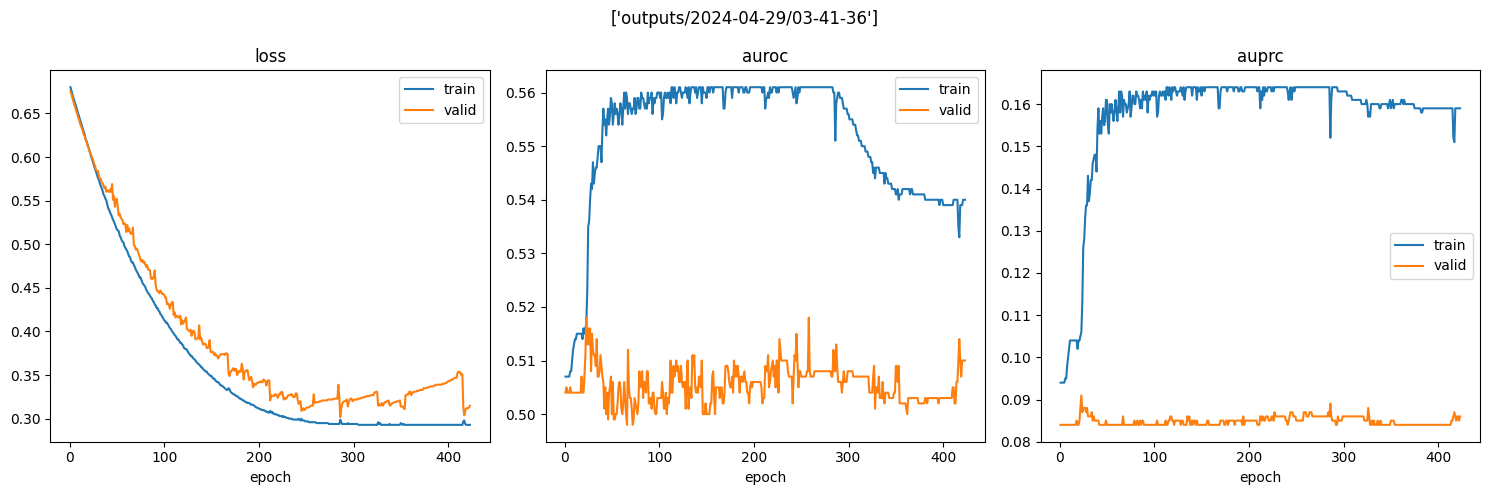

In [6]:
plot_metrics(df_metrics, run = run, metrics=['loss', 'auroc', 'auprc'], folds=['train', 'valid'])

In [7]:
best = get_best_epoch(df_metrics, run='outputs/2024-04-29/03-41-36')
best

286

In [8]:
get_metric_at_epoch(df_metrics, best, run)

0.089

In [9]:
df_exp.loc[df_exp['run']==run, ['src_data', 'task', 'value_mode', 'embed_model', 'tag']]

,src_data,task,value_mode,embed_model,tag
304,mimiciii,mortality,DSVA,descemb_bert,DescEmb-BERT_CLS-FT


In [17]:
idx = df_exp.loc[(df_exp['src_data']=='mimiciii') & (df_exp['tag']=='DescEmb-BERT_CLS-FT'), ['task', 'value_mode',]].index

In [18]:
idx

Int64Index([218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
            231, 232, 233, 234, 235, 236, 237, 299, 300, 301, 302, 303, 304],
           dtype='int64')

In [33]:
tags = df_exp.tag.unique()
tags

array(['DescEmb-RNN_Scr', 'CodeEmb_RD', 'unknown',
       'DescEmb-RNN_Pretrain-MLM', 'DescEmb-BERT_FT-MLM',
       'DescEmb-BERT_Scr', 'DescEmb-BERT_CLS-FT', 'DescEmb-BERT_FT',
       'DescEmb-BERT_Pretrain-MLM', 'DescEmb-BERT_Transfer'], dtype=object)

In [56]:
t = ['A', 'B']
sorted(t*5)

['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']

In [59]:
table = pd.DataFrame()
table['task'] = sorted(list(['diagnosis', 'mortality', 'los>3', 'los>7', 'readmission'])*4)
table['value_mode'] = ['VA', 'DSVA', 'DSVA-DPE', 'VC']*5

In [60]:
table

,task,value_mode
0,diagnosis,VA
1,diagnosis,DSVA
2,diagnosis,DSVA-DPE
3,diagnosis,VC
4,los>3,VA
5,los>3,DSVA
6,los>3,DSVA-DPE
7,los>3,VC
8,los>7,VA
9,los>7,DSVA


In [68]:
tags = ['DescEmb-BERT_FT-MLM', 'DescEmb-BERT_CLS-FT', 'DescEmb-BERT_FT'] #df_exp.tag.unique()
src_data = 'mimiciii'
table = pd.DataFrame()
table['task'] = sorted(list(['diagnosis', 'mortality', 'los>3', 'los>7', 'readmission'])*4)
table['value_mode'] = ['VA', 'DSVA', 'DSVA-DPE', 'VC']*5
for tag in tqdm(tags): # = 'DescEmb-BERT_CLS-FT'
    exp = df_exp.loc[(df_exp['src_data']==src_data) & (df_exp['tag']==tag), ['task', 'value_mode',]]
    idx = exp.index
    auprc = []
    for run in df_exp.iloc[idx].run:
        #print(f"Processing tag {tag}, run {run}")
        try:
            best = get_best_epoch(df_metrics, run=run)
            auprc.append(get_metric_at_epoch(df_metrics, best, run))
        except:
            print(f"Error in {run}")
            auprc.append(np.nan)
    exp[tag] = auprc
    try:
        table = pd.merge(table, exp, on=['task', 'value_mode'], how='left')
    except:
        pass

100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


In [69]:
table.head(200)

,task,value_mode,DescEmb-BERT_FT-MLM,DescEmb-BERT_CLS-FT,DescEmb-BERT_FT
0,diagnosis,VA,0.623,0.645,0.644
1,diagnosis,VA,0.623,0.645,0.639
2,diagnosis,VA,0.635,0.645,0.644
3,diagnosis,VA,0.635,0.645,0.639
4,diagnosis,DSVA,0.627,0.647,0.648
...,...,...,...,...,...
62,readmission,VC,0.051,0.046,0.047
63,readmission,VC,0.046,0.045,0.045
64,readmission,VC,0.046,0.045,0.047
65,readmission,VC,0.046,0.046,0.045


### Single Domain Learning 

We already worked on running single domain training with a subset of the available conditions using the full MIMIC-III dataset. Since pretraining with MLM was not successful we could only use model training from scratch (in the case of RNN). Thus, results are way sub-par, but we get an overview of which experiments at least finished training and we established the infrastructure for training and experiment tracking to run the full experiments once the pretraining issue is resolved.

In [6]:
import pandas as pd

In [9]:
df = pd.read_excel('outputs/experiments.xlsx') # read the experiments.xlsx file

In [11]:
df.tail(10)

,run,done,src_data,task,embed_model,model,value_mode,auprc
127,outputs/2024-04-13/22-41-37,True,mimiciii,diagnosis,codeemb,ehr_model,NV,0.642
128,outputs/2024-04-13/22-49-32,True,mimiciii,diagnosis,codeemb,ehr_model,VA,0.636
129,outputs/2024-04-13/22-56-37,True,mimiciii,diagnosis,codeemb,ehr_model,DSVA,0.643
130,outputs/2024-04-13/23-04-16,False,mimiciii,diagnosis,codeemb,ehr_model,VC,NaN
131,outputs/2024-04-11/06-58-08,True,mimiciii,mortality,descemb_rnn,ehr_model,NV,0.089
132,outputs/2024-04-11/07-13-10,True,mimiciii,mortality,codeemb,ehr_model,NV,0.094
133,outputs/2024-04-11/07-14-13,True,mimiciii,mortality,descemb_rnn,ehr_model,DSVA_DPE,0.089
134,outputs/2024-04-11/07-18-52,True,mimiciii,mortality,descemb_rnn,ehr_model,VC,0.089
135,outputs/2024-04-11/07-23-05,True,mimiciii,mortality,descemb_rnn,ehr_model,DSVA,0.089
136,outputs/2024-04-11/07-26-56,True,mimiciii,mortality,descemb_rnn,ehr_model,VA,0.089


The left two columns are for our internal bookkeeping. `done` is True, if training finished successfully as parsed from the end of the log file. The right columns is the AUPRC for the test set.


In [12]:
# Only finished experiments
df_finished = df[df.done==True]

In [13]:
# All auprc values for codeemb
df_finished.loc[df_finished.embed_model == 'codeemb', ['src_data', 'task', 'value_mode', 'auprc']]

,src_data,task,value_mode,auprc
111,mimiciii,readmission,NV,0.047
112,mimiciii,readmission,VA,0.043
113,mimiciii,readmission,DSVA,0.043
115,mimiciii,mortality,NV,0.094
116,mimiciii,mortality,VA,0.090
117,mimiciii,mortality,DSVA,0.090
120,mimiciii,los_3day,VA,0.349
121,mimiciii,los_3day,DSVA,0.350
123,mimiciii,los_7day,NV,0.133
124,mimiciii,los_7day,VA,0.129


The AUPRC values we obtained so far are below what we expected. We attribute this to two main reasons:
* Preprocessing may still have issues. 
* We need to pretrain CodeEmb with the W2V task before training the prediction tasks.
     

In [16]:
# All auprc values for descemb-rnn
df_finished.loc[df_finished.embed_model == 'descemb_rnn', ['src_data', 'task', 'value_mode', 'auprc']]

,src_data,task,value_mode,auprc
41,mimiciii,readmission,NV,0.043
42,mimiciii,readmission,VA,0.043
45,mimiciii,readmission,VC,0.043
46,mimiciii,mortality,NV,0.089
47,mimiciii,mortality,VA,0.089
48,mimiciii,mortality,DSVA,0.089
49,mimiciii,mortality,DSVA_DPE,0.090
50,mimiciii,mortality,VC,0.090
51,mimiciii,los_3day,NV,0.350
52,mimiciii,los_3day,VA,0.357


DescEmb with RNN encoder is even more affected by the lack of pretraining. The AUPRC values are very much below what the authors reported.
It makes sense that this architecture can compensate less for the lack of pretraining compared to CodeEmb. In the latter there is only an Embedding layer to train, while in the former there is the whole RNN model.

# Discussion and Plan
To start with we really appreciate the authors made comprehensive code available. This is a great help for reproducibility. However, the code has some issues and some command-line options are not well documented. We learned what arguments are available by looking at the source code. It is still challenging to map all the options to the tables in the paper.

So far we had issues with the preprocessing, which likely lead to issues downstream. 
Another issue we observed was that pretraining models using the masked language model (MLM) target was not working. This will be one important issue to fix in the next phase. We narrowed it down to `MLMTokenizedDataset` taking excessive amounts of time, so we will try to optimize this part.

We have been successful at running single domain training (albeit with poor AUPRC results). The poor results likely are caused by the preprocessing issues and lack of proper pre-training. We will try to fix these issues in the next phase.

Concrete next steps:
* Fix the preprocessing issues (we will try get in touch with the authors to get a better understanding of the preprocessing)
* Fix the pretraining issues, especially the MLM pretraining. Success will critically depend on this part. 
* Then run at least:
  - MLM pretraining 
  - CLS-finetuning
  - Single domain training
  - Transfer learning
  - Pooled data training

We will likely not train BERT-tiny from scratch, because it is very computationally expensive and the authors found that it did not help very much over fine-tuning.

### Technical issues

Apart from aforementioned issues with preprocessing and pretraining, we also had some issues with the training code. The training assumes multi-GPU training, which we had to modify to run on a single GPU. We also had some issues with the data loaders, which we had to modify to run on a single GPU.
Given the age of the publication the authors used `nn.DataParallels` for multi-GPU training, which is now deprecated in PyTorch. We will NOT try to update the code to use `torch.nn.parallel.DistributedDataParallel` instead, because we wish to avoid multi-GPU training due to cost constraints.

### Hypothesis 4 - DescEmb outperforms CodeEmb in predicting patient outcomes

The authors report that *DescEmb* outperforms *CodeEmb* in most tasks. 
The basis for which they make this claim is the AUPRC metric on five tasks: Dx, Mort, LOS>3, LOS>7, ReAdm. [Wornow et al. (2023)](#references) criticize the use of AUPRC as the sole metric for evaluation in combination with a narrow set of prediciton tasks. They argue that the tasks used were not always overlapping with other publications thus making it hard to compare the results. Wornow et al. (2023) provide a taxonomy of medical foundation models. According to this taxonomy the tasks used in this paper would fall under the category of "prediction tasks" by an FEMR. 

![](assets/Clams_Femrs.png)


While in NLP tasks standardized benchmarks exist, such as BLUE and ROUGE the same is not always true in the medical domain. However, there have been some efforts to standardize the evaluation of medical NLP tasks, such as the BLURB benchmark put forward by [Gu et al. (2022)](#references). To the best of our knowledge the same is unfortunately not true for the tasks used in this paper.

### Hypothesis 5 - Using a BERT model pre-trained on a domain-specific dataset 
To assess if such a domain-specific pre-training improve the can an improve performance we plan to replace the AutoTokenizer in the `BaseDataset` by one derived from `PubMedBERT` as reported by Gu et al (2022). Then we could run pre-training and pooled training with this tokenization.

# References <a id="references"></a>

1.   Kyunghoon Hur, Jiyoung Lee, Jungwoo Oh, Wesley Price, Young-Hak Kim, and Edward Choi. Uni-
fying Heterogeneous Electronic Health Records Systems via Text-Based Code Embedding, March 2022, arXiv:2108.03625, doi: 10.48550/arXiv.2108.03625.
2. Pollard, Tom, et al. "eICU Collaborative Research Database" (version 2.0). PhysioNet (2019), https://doi.org/10.13026/C2WM1R.
3. Johnson, Alistair, et al. "MIMIC-III Clinical Database" (version 1.4). PhysioNet (2016), https://doi.org/10.13026/C2XW26.
4. Wornow, Michael, Yizhe Xu, Rahul Thapa, Birju Patel, Ethan Steinberg, Scott Fleming, Michael A. Pfeffer, Jason Fries, and Nigam H. Shah. "The Shaky Foundations of Clinical Foundation Models: A Survey of Large Language Models and Foundation Models for EMRs." March 2023, arXiv:2303.12961, doi: 10.48550/arXiv.2303.12961.
5. Gu, Yu, Robert Tinn, Hao Cheng, Michael Lucas, Naoto Usuyama, Xiaodong Liu, Tristan Naumann, Jianfeng Gao, and Hoifung Poon. "Domain-Specific Language Model Pretraining for Biomedical Natural Language Processing." January 2022, arXiv:2007.15779, doi: 10.1145/3458754.

